In [1]:
import pandas as pd
import numpy as np
import os, sys
import cv2
import matplotlib.pyplot as plt
import copy
import tensorflow as tf
from io import StringIO # Python3 use: from io import StringIO
import seaborn as sns

models = tf.keras.models  # like 'from tensorflow.keras import models' (PyCharm import issue workaround)
layers = tf.keras.layers  # like 'from tensorflow.keras import layers' (PyCharm import issue workaround)

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

DATA = os.path.join(module_path, 'Data', 'Augmented Data', 'Flexible Augmentation')
RESULTS = os.path.join(module_path, 'Results', 'Thesis')
FIGURES = os.path.join(module_path, 'Figures', 'Thesis')
from Scripts import Data_Loader_Functions as DL
from Scripts import Model_Architectures as mA
from Scripts import Results_Evaluation as rE

In [ ]:
def create_simple_grid(file_paths, y_ticks, metric, top_exp):
    colors = ['#CD6155', '#2E86C1']
    styles = ['-','--']
    
    # Create Figure
    fig = plt.figure(figsize=(18, 16))
    fig.subplots_adjust(hspace=0.4, wspace=0.2)
    for i, file_path in enumerate(file_paths):
        
        # Add figure to subplot and read in data frame (session 0 is the 'pre-training session')
        ax = fig.add_subplot(len(file_paths) // 2 + 1, 2, i + 1)
        df = pd.read_excel(file_path)
        df = df[df['Session'] != 0]
        
        # Prepare dataframe for plotting
        metrics = [metric, 'val_' + metric]
        df_plot = df[metrics]
        df_plot = df_plot.rename(columns={metrics[0]: 'Train ' + metric, metrics[1]: 'Validation ' + metric})
        df_plot.plot(ax=ax, style=styles, color=colors)
        
        # Add vertical lines indicating sessions
        for i, val in enumerate(df[df['Epoch'] == 0].index.values):
            ax.axvline(val, c='#C2C5CC', ls=':')
            plt.text(val + 1, 0.02, 'S: {}'.format(i+1))
            
        # Set title and legends
        ax.set_title(top_exp[file_path.split('Plotting/')[1]])
        ax.set_yticks(y_ticks)
        ax.set_xlabel('Federated Communication Rounds / Centralized Epochs')
    
    plt.tight_layout()
    return fig, ax

In [2]:
def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        plt.annotate('{:.0%}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')

In [3]:
def draw_pain_bar_chart():
    # Create Dataframe
    df = pd.DataFrame(DL.get_labels(DL.get_image_paths(os.path.join(DATA, 'group_2'))), columns=['Person', 'Session', 'Culture', 'Frame', 'Pain', 'Trans_1', 'Trans2'])
    df[['Person', 'Session', 'Culture', 'Frame', 'Pain', ]] = df[['Person', 'Session', 'Culture', 'Frame', 'Pain', ]].astype(int)
    
    # Get Frequencey values
    sessions = sorted(df['Session'].unique())
    share_1 = {}
    for session in sessions:
        key, val = np.unique(df[df['Session'] == session]['Pain'], return_counts=True)
        if 1 in key:
            share_1[session] = val[1] / sum(val[1:])
    
    # Draw figure
    plt.figure(figsize=(10,5))
    bars = plt.bar(share_1.keys(), share_1.values(), color='#2E86C1')
    autolabel(bars)
    bars[2].set_color('#CD6155')
    bars[5].set_color('#CD6155')
    plt.xticks(np.arange(0,10,1))
    plt.yticks(np.arange(0,1.1,0.2), ['{}%'.format(int(num * 100)) for num in np.arange(0,1.1,0.2)])
    plt.xlabel('Sessions')
    plt.ylabel("Share of Pain Level '1'")
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle='--')
    fig = plt.gcf()
    return fig, ax

In [4]:
def create_pain_df(path, pain_gap=()):
    img_paths = np.array(DL.get_image_paths(path))
    labels = np.array(DL.get_labels(img_paths))
    df = pd.DataFrame(labels, columns=['Person', 'Session', 'Culture', 'Frame', 'Pain', 'Trans_1', 'Trans_2'])
    df[['Person', 'Session', 'Culture', 'Frame', 'Pain']] = df[
        ['Person', 'Session', 'Culture', 'Frame', 'Pain']].astype(int)
    df['img_path'] = img_paths
    df[['Trans_1', 'Trans_2', 'img_path']] = df[['Trans_1', 'Trans_2', 'img_path']].astype(str)
    df = df.sort_values(['Person', 'Session', 'Frame', 'Trans_1', 'Trans_2'],
                        ascending=[True, True, True, False, False]).reset_index(drop=True)
    df['temp_id'] = df['Person'].astype(str) + df['Session'].astype(str) + df['Frame'].astype(str)
    df = df[~df['Pain'].isin(pain_gap)]
    return df

In [5]:
def model_summary_to_df(model, mystdout):
    model.summary(line_length=100)
    model_summary = mystdout.getvalue()
    a = model_summary.split('\n')
    a = a[4:-5]
    a = a[::2]
    for idx, elem in enumerate(a):
        a[idx] = [elem[:45], elem[45:85], elem[85:]]
    return pd.DataFrame(a, columns=['Layer Type', 'Output Shape', 'Param #'])

In [6]:
def format_df(df):
    df['Layer Type'] = df['Layer Type'].map(lambda x: x.split('(')[1].split(')')[0])
    df['Param #'] = df['Param #'].astype(float)
    df = df.append(df.sum(numeric_only=True), ignore_index=True)
    df.loc[len(df)-1, 'Layer Type'] = 'Total'
    df['Param #'] = df['Param #'].apply("{0:,.0f}".format)
    return df.fillna('')

In [7]:
def model_summary():
    model_1 = build_CNN((215, 215, 1))
    old_stdout = copy.copy(sys.stdout)
    sys.stdout = mystdout = StringIO()
    df = model_summary_to_df(model_1, mystdout)
    df = format_df(df)
    df = pd.concat((pd.DataFrame([{'Layer Type': 'Input', 'Output Shape': '(None, 215, 215, 1)',  'Param #': 0}]), df), ignore_index=True)
    return df, old_stdout

In [8]:
def build_CNN(input_shape):
    """
    Return a simple CNN model for image classification.

    :param input_shape:     image input shape (tuple), e.g. (28, 28, 1)

    :return:
        model               compiled tensorflow model
    """

    print("Setting up CNN")
    # Set up model type
    model = models.Sequential(name='CNN')

    # Add layers
    model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), input_shape=input_shape, padding='same', strides=(2, 2),
                            name='conv2d_0_global'))
    model.add(layers.BatchNormalization(name='batch_norm_0_global'))
    model.add(layers.ReLU(name='relu_0_global'))
    # model.add(layers.MaxPooling2D(name='max_pool_0_global'))

    model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), padding='same', strides=(2, 2), name='conv2d_1_global'))
    model.add(layers.BatchNormalization(name='batch_norm_1_global'))
    model.add(layers.ReLU(name='relu_1_global'))
    # model.add(layers.MaxPooling2D(name='max_pool_1_global'))

    model.add(layers.Conv2D(filters=128, kernel_size=(5, 5), padding='same', strides=(2, 2), name='conv2d_2_global'))
    model.add(layers.BatchNormalization(name='batch_norm_2_global'))
    model.add(layers.ReLU(name='relu_2_global'))
    model.add(layers.MaxPooling2D(name='max_pool_2_global'))

    model.add(layers.Flatten(name='flatten_0_local'))
    model.add(layers.Dense(units=128, name='dense_0_local'))
    model.add(layers.BatchNormalization(name='batch_norm_3_local'))
    model.add(layers.ReLU(name='relu_3_local'))
    model.add(layers.Dense(units=1, activation='sigmoid', name='dense_1_local'))

    return model

# Load Dataset

In [9]:
df = create_pain_df(DATA)

# Original Images

In [10]:
df_original = df[(df['Trans_1'] == 'original') & (df['Trans_2'] == 'straight')]

### Total images

In [11]:
len(df_original)

48106

### Pain Distribution - Whole Dataset

In [12]:
df_pain_levels = pd.DataFrame(np.unique(df_original['Pain'], return_counts=True)).T.rename(columns={0: 'Pain Level', 1: "Count"})
df_pain_levels['%'] = round(df_pain_levels['Count'] / df_pain_levels['Count'].sum(), 3) * 100
df_pain_levels['Count'] = df_pain_levels['Count'].apply("{0:,.0f}".format)
print(df_pain_levels.to_latex(index=False))

\begin{tabular}{rlr}
\toprule
 Pain Level &   Count &     \% \\
\midrule
          0 &  39,846 &  82.8 \\
          1 &   3,100 &   6.4 \\
          2 &   2,281 &   4.7 \\
          3 &   1,408 &   2.9 \\
          4 &     801 &   1.7 \\
          5 &     241 &   0.5 \\
          6 &     265 &   0.6 \\
          7 &      53 &   0.1 \\
          8 &      79 &   0.2 \\
          9 &      32 &   0.1 \\
\bottomrule
\end{tabular}



### Histogram Equilization

In [13]:
# Set PLT Parameters
plt.rcParams.update({'font.size': 14, 
                     'font.family' : 'cmr10', 
                     'font.weight' : 'normal',
                     'axes.titlesize' : 18})

In [14]:
grey = cv2.imread(os.path.join('Dummy Data', '47_0_0_0_0_grey.png'), 0).flatten()
hist_eq = cv2.imread(os.path.join('Dummy Data', '47_0_0_0_0_hist.jpg'), 0).flatten()

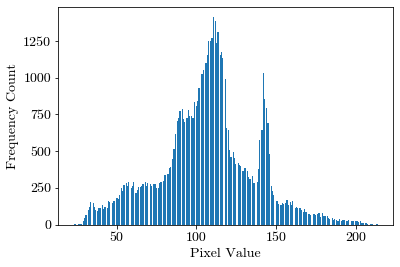

In [15]:
ax1 = plt.hist(grey, 256)
plt.ylabel('Frequency Count')
plt.xlabel('Pixel Value')
plt.savefig('histogram.pdf', dpi=300)

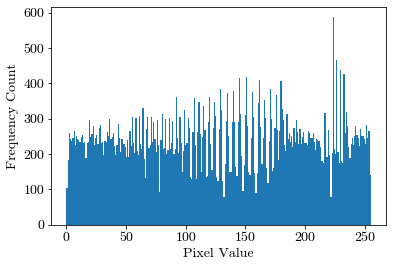

In [16]:
ax1 = plt.hist(hist_eq, 256)
plt.ylabel('Frequency Count')
plt.xlabel('Pixel Value')
plt.savefig('histogram_eq.pdf', dpi=300)

### Pain vs. No Pain

In [17]:
print(sum(df_original['Pain'] == 0),"|", sum(df_original['Pain'] > 0))

39846 | 8260


### Group 1 vs. Group 2

In [18]:
df_1 = create_pain_df(os.path.join(DATA, "group_1"))
df_2 = create_pain_df(os.path.join(DATA, "group_2"))
print(len(df_1), "|", len(df_2))

102976 | 78180


In [19]:
df_p_1 = pd.DataFrame(df_1['Person'].unique(), columns=['Group 1'])
df_p_2 = pd.DataFrame(df_2['Person'].unique(), columns=['Group 2'])
df_p = pd.concat((df_p_1, df_p_2), sort=False, axis=1).T
print(df_p.to_latex(header=False))

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
Group 1 &  42 &  47 &  49 &  66 &  95 &  97 &  103 &  106 &  108 &  121 &  123 &  124 \\
Group 2 &  43 &  48 &  52 &  59 &  64 &  80 &   92 &   96 &  107 &  109 &  115 &  120 \\
\bottomrule
\end{tabular}



In [20]:
df['Person'].unique()

array([ 42,  43,  47,  48,  49,  52,  59,  64,  66,  80,  92,  95,  96,
        97, 101, 103, 106, 107, 108, 109, 115, 120, 121, 123, 124])

## Person

In [21]:
df_original = df_original.copy()
df_original['Pain'] = np.minimum(df_original['Pain'], 1)
no_pain = df_original.groupby('Person')['Pain'].count() - df_original.groupby('Person')['Pain'].sum()
pain = df_original.groupby('Person')['Pain'].sum()
no_pain.name = 'No Pain'
pain_df = pd.concat((pd.DataFrame(no_pain), pd.DataFrame(pain)), axis=1)
pain_df['% Pain'] = (pain_df['Pain'] / pain_df.sum(axis=1) * 100).astype(int).astype(str) + '%'
pain_df = pain_df.reset_index()
pain_df['Pain'] = pain_df['Pain'].apply("{0:,.0f}".format)
pain_df['No Pain'] = pain_df['No Pain'].apply("{0:,.0f}".format)
pain_1 = pain_df[pain_df['Person'].isin(df_p_1['Group 1'])]
pain_2 = pain_df[pain_df['Person'].isin(df_p_2['Group 2'])]
array = [['Group 1', 'Group 1', 'Group 1', 'Group 1'], list(pain_1.columns.values)]
tuples = list(zip(*array))
idx1 = pd.MultiIndex.from_tuples(tuples)
array = [['Group 2', 'Group 2', 'Group 2', 'Group 2'], list(pain_2.columns.values)]
tuples = list(zip(*array))
idx2 = pd.MultiIndex.from_tuples(tuples)
pain_1.columns = idx1
pain_2.columns = idx2
print(pain_1.to_latex(index=False))
print(pain_2.to_latex(index=False))

\begin{tabular}{rlll}
\toprule
Group 1 \\
 Person & No Pain & Pain & \% Pain \\
\midrule
     42 &   1,895 &  239 &    11\% \\
     47 &   1,544 &   64 &     3\% \\
     49 &   2,194 &  524 &    19\% \\
     66 &   1,947 &  512 &    20\% \\
     95 &     304 &  498 &    62\% \\
     97 &   3,212 &  147 &     4\% \\
    103 &   2,738 &  824 &    23\% \\
    106 &   2,281 &  517 &    18\% \\
    108 &   2,453 &  455 &    15\% \\
    121 &     478 &   40 &     7\% \\
    123 &     822 &  361 &    30\% \\
    124 &     699 &  996 &    58\% \\
\bottomrule
\end{tabular}

\begin{tabular}{rlll}
\toprule
Group 2 \\
 Person & No Pain &   Pain & \% Pain \\
\midrule
     43 &   1,028 &     92 &     8\% \\
     48 &     798 &     84 &     9\% \\
     52 &   2,503 &    106 &     4\% \\
     59 &     640 &    133 &    17\% \\
     64 &   1,394 &    155 &    10\% \\
     80 &     896 &  1,068 &    54\% \\
     92 &   1,031 &    471 &    31\% \\
     96 &   2,175 &    178 &     7\% \\
    107 &   1,599

## Pain Pivot

In [22]:
index = 'Person'
columns = 'Session'
values = index
pivot = DL.create_pivot(os.path.join(DATA, "group_2"), index, columns, values)
pivot['Pain %'] = (pivot['Pain %'] * 100).astype(int).astype(str) + '%'
pivot = pivot.drop('Total')
pivot = pivot.reset_index()
array = [[' ', 'Session', 'Session', 'Session', 'Session', 'Session', 'Session', 'Session', 'Session', 'Session', 'Session', 'Total', 'Total', 'Total', 'Total'], list(pivot.columns.values)]
tuples = list(zip(*array))
index = pd.MultiIndex.from_tuples(tuples)
pivot.columns = index
pivot = pivot.sort_values([(' ', 'Person')], ascending=True)
pivot['Session'] = pivot['Session'][pivot['Session'] != ''].astype(float).applymap("{0:,.0f}".format).replace('nan', '')
pivot[('Total', 'Pain')] = pivot[('Total', 'Pain')].astype(float).apply("{0:,.0f}".format)
pivot[('Total', 'No Pain')] = pivot[('Total', 'No Pain')].astype(float).apply("{0:,.0f}".format)
print(pivot.to_latex(index=False))

\begin{tabular}{rllllllllllrlll}
\toprule
       & \multicolumn{10}{l}{Session} & \multicolumn{4}{l}{Total} \\
Person &       0 &    1 &    2 &    3 &    4 &    5 &    6 & 7 &    8 &    9 & \# of Sessions &   Pain & No Pain & Pain \% \\
\midrule
    43 &     140 &      &      &      &  228 &      &      &   &      &      &             9 &    368 &   4,112 &     8\% \\
    48 &         &  148 &      &      &      &  188 &      &   &      &      &             7 &    336 &   3,192 &    10\% \\
    52 &      72 &      &      &      &      &      &   44 &   &  120 &  188 &            10 &    424 &  10,012 &     4\% \\
    59 &         &  532 &      &      &      &      &      &   &      &      &             2 &    532 &   2,560 &    17\% \\
    64 &     244 &   64 &   64 &      &  248 &      &      &   &      &      &             6 &    620 &   5,576 &    10\% \\
    80 &   1,052 &  536 &  484 &  484 &  660 &  792 &  264 &   &      &      &             7 &  4,272 &   3,584 &    54\% \\
    

## Model Architectures

In [23]:
PADDING = 'same'
BATCH_NORM = True
RELU = True
MAX_POOL = True
GLOB_MAX_POOL = True
STRIDE = (1, 1)

df, stdout = model_summary()
sys.stdout = stdout
print(df.to_latex(index=False))

Setting up CNN
\begin{tabular}{lll}
\toprule
         Layer Type &                              Output Shape &    Param \# \\
\midrule
              Input &                       (None, 215, 215, 1) &          0 \\
             Conv2D &  (None, 108, 108, 32)                     &        832 \\
 BatchNormalization &  (None, 108, 108, 32)                     &        128 \\
               ReLU &  (None, 108, 108, 32)                     &          0 \\
             Conv2D &  (None, 54, 54, 64)                       &     51,264 \\
 BatchNormalization &  (None, 54, 54, 64)                       &        256 \\
               ReLU &  (None, 54, 54, 64)                       &          0 \\
             Conv2D &  (None, 27, 27, 128)                      &    204,928 \\
 BatchNormalization &  (None, 27, 27, 128)                      &        512 \\
               ReLU &  (None, 27, 27, 128)                      &          0 \\
       MaxPooling2D &  (None, 13, 13, 128)                      &

## Performance Tables

In [24]:
# Define Variables
pivot = DL.create_pivot(os.path.join(DATA, 'group_2'), 'Session', 'Person', 'Session')
subjects = DL.create_pain_df(os.path.join(DATA, 'group_2'))['Person'].unique()

In [25]:
# Define experiment names
exp_names = {
   '0-sessions-Baseline-central-pre-training': 'BC-CNN',
   '0-sessions-Baseline-federated-pre-training': 'BF-CNN',
   '1-sessions-Centralized-no-pre-training': 'C-CNN (N)',
   '10-sessions-Federated-central-pre-training-local-models': 'FL-CNN (C)',
   '11-sessions-Federated-federated-pre-training-local-models': 'FL-CNN (F)',
   '2-sessions-Centralized-pre-training': 'C-CNN (C)',
   '3-sessions-Federated-no-pre-training': 'F-CNN (N)',
   '4-sessions-Federated-central-pre-training': 'F-CNN (C)',
   '5-sessions-Federated-federated-pre-training': 'F-CNN (F)',
   '6-sessions-Federated-no-pre-training-personalization': 'FP-CNN (N)',
   '7-sessions-Federated-central-pre-training-personalization': 'FP-CNN (C)',
   '8-sessions-Federated-federated-pre-training-personalization': 'FP-CNN (F)',
   '9-sessions-Federated-no-pre-training-local-models': 'FL-CNN (N)'
}

In [26]:
# Define top experiments
top_exp = ['BC-CNN', 'C-CNN (C)', 'F-CNN (C)', 'FP-CNN (C)', 'FL-CNN (C)']

In [28]:
results = rE.compute_average_metrics('person', subjects, pivot, RESULTS)
overview_table = rE.generate_overview_table(results, exp_names)

### Overall

In [29]:
print(overview_table.to_latex(index=False))

\begin{tabular}{llll}
\toprule
            & \multicolumn{3}{l}{Weighted AVG + STD} \\
 Experiment &                ACC &   PR-AUC &       F1 \\
\midrule
     BC-CNN &            72 ± 11 &  53 ± 23 &  47 ± 23 \\
     BF-CNN &            73 ± 11 &  53 ± 22 &  45 ± 19 \\
  C-CNN (N) &            68 ± 15 &  47 ± 22 &  36 ± 23 \\
  C-CNN (C) &            75 ± 13 &  57 ± 20 &  50 ± 21 \\
  F-CNN (N) &            66 ± 14 &  48 ± 22 &  42 ± 24 \\
  F-CNN (C) &            74 ± 11 &  58 ± 23 &  51 ± 24 \\
  F-CNN (F) &            76 ± 11 &  58 ± 22 &  49 ± 24 \\
 FP-CNN (N) &            69 ± 15 &  43 ± 18 &  34 ± 23 \\
 FP-CNN (C) &            76 ± 12 &  55 ± 21 &  48 ± 23 \\
 FP-CNN (F) &            76 ± 13 &  55 ± 20 &  44 ± 22 \\
 FL-CNN (N) &            69 ± 16 &  42 ± 17 &  33 ± 24 \\
 FL-CNN (C) &            74 ± 13 &  54 ± 20 &  46 ± 23 \\
 FL-CNN (F) &            75 ± 13 &  54 ± 20 &  42 ± 22 \\
\bottomrule
\end{tabular}



In [30]:
# Print top experiments
print(overview_table[overview_table[('', 'Experiment')].isin(top_exp)].to_latex(index=False))

\begin{tabular}{llll}
\toprule
            & \multicolumn{3}{l}{Weighted AVG + STD} \\
 Experiment &                ACC &   PR-AUC &       F1 \\
\midrule
     BC-CNN &            72 ± 11 &  53 ± 23 &  47 ± 23 \\
  C-CNN (C) &            75 ± 13 &  57 ± 20 &  50 ± 21 \\
  F-CNN (C) &            74 ± 11 &  58 ± 23 &  51 ± 24 \\
 FP-CNN (C) &            76 ± 12 &  55 ± 21 &  48 ± 23 \\
 FL-CNN (C) &            74 ± 13 &  54 ± 20 &  46 ± 23 \\
\bottomrule
\end{tabular}



## Per Person

In [32]:
results = rE.compute_average_metrics('person', subjects, pivot, RESULTS)
print(rE.prepare_top_experiments(results['accuracy'], exp_names, top_exp).to_latex(index=False))
print(rE.prepare_top_experiments(results['f1_score'], exp_names, top_exp).to_latex(index=False))
print(rE.prepare_top_experiments(results['roc'], exp_names, top_exp).to_latex(index=False))

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 Experiment &  43 &  48 &  52 &  59 &  64 &  80 &  92 &  96 &  107 &  109 &  115 &  120 \\
\midrule
     BC-CNN &  69 &  78 &  91 &  50 &  90 &  56 &  67 &  78 &   64 &   75 &   69 &   72 \\
  C-CNN (C) &  80 &  78 &  78 &  50 &  92 &  63 &  71 &  83 &   69 &   76 &   89 &   66 \\
  F-CNN (C) &  70 &  78 &  90 &  50 &  91 &  60 &  70 &  83 &   70 &   69 &   74 &   68 \\
 FP-CNN (C) &  82 &  78 &  86 &  50 &  91 &  61 &  75 &  82 &   67 &   76 &   90 &   72 \\
 FL-CNN (C) &  83 &  78 &  85 &  50 &  91 &  60 &  64 &  82 &   66 &   76 &   89 &   72 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 Experiment &  43 &  48 &  52 &  59 &  64 &  80 &  92 &  96 &  107 &  109 &  115 &  120 \\
\midrule
     BC-CNN &  21 &   4 &  32 &  57 &  21 &  61 &  78 &   6 &   58 &   32 &   34 &   64 \\
  C-CNN (C) &  66 &   7 &  27 &  57 &  37 &  55 &  65 &  44 &   63 &   36 &   45 &   63 \\
  F-CNN (C) &  28 &   6 &  44 &  57 &  24 &  58 &  80 & 

## Per Session

In [33]:
results = rE.compute_average_metrics('session', subjects, pivot, RESULTS)
print(rE.prepare_top_experiments(results['accuracy'], exp_names, top_exp).to_latex(index=False))
print(rE.prepare_top_experiments(results['f1_score'], exp_names, top_exp).to_latex(index=False))
print(rE.prepare_top_experiments(results['roc'], exp_names, top_exp).to_latex(index=False))

\begin{tabular}{lrrrrrrlrr}
\toprule
 Experiment &   1 &   2 &   3 &   4 &   5 &   6 &   7 &   8 &   9 \\
\midrule
     BC-CNN &  68 &  61 &  76 &  71 &  70 &  68 &  NA &  88 &  95 \\
  C-CNN (C) &  68 &  75 &  82 &  78 &  64 &  78 &  NA &  79 &  77 \\
  F-CNN (C) &  68 &  72 &  79 &  73 &  60 &  79 &  NA &  87 &  94 \\
 FP-CNN (C) &  68 &  74 &  83 &  78 &  64 &  77 &  NA &  84 &  88 \\
 FL-CNN (C) &  68 &  73 &  84 &  73 &  64 &  78 &  NA &  83 &  87 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrrlrr}
\toprule
 Experiment &   1 &   2 &   3 &   4 &   5 &   6 &   7 &   8 &   9 \\
\midrule
     BC-CNN &  49 &  49 &  48 &  65 &  17 &  36 &  NA &   4 &  73 \\
  C-CNN (C) &  49 &  54 &  52 &  66 &   5 &  31 &  NA &  25 &  45 \\
  F-CNN (C) &  49 &  53 &  51 &  68 &  26 &  43 &  NA &  12 &  76 \\
 FP-CNN (C) &  49 &  51 &  56 &  68 &   5 &  21 &  NA &  26 &  58 \\
 FL-CNN (C) &  49 &  43 &  57 &  60 &   8 &  24 &  NA &  20 &  55 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrrlrr

## Training Metrics Plots

In [34]:
experiment = '132 - Seed 132'

### Prepare variables

In [35]:
# Concatenate results if necessary
experiment_folder = os.path.join(RESULTS, experiment)
plotting_folder = os.path.join(experiment_folder, 'Plotting')
rE.concat_validation_metrics(experiment_folder)

In [57]:
# Define top experiments
top_exp = {'2019-08-29_PAIN_2-sessions-Centralized-pre-training.xlsx': 'C-CNN (C)', 
           '2019-08-29_PAIN_4-sessions-Federated-central-pre-training.xlsx': 'F-CNN (C)', 
           '2019-08-29_PAIN_7-sessions-Federated-central-pre-training-personalization.xlsx': 'FP-CNN (C)',
           '2019-08-29_PAIN_10-sessions-Federated-central-pre-training-local-models.xlsx': 'FL-CNN (C)'}

In [58]:
# Set PLT Parameters
plt.rcParams.update({'font.size': 19, 
                     'font.family' : 'cmr10', 
                     'font.weight' : 'normal',
                     'axes.titlesize' : 22})

In [59]:
# Find and sort file paths
file_paths = [os.path.join(plotting_folder, file) for file in sorted(os.listdir(plotting_folder)) if file in top_exp]
order = [int(file_path.split('PAIN_')[1].split('-')[0]) for file_path in file_paths]
file_paths = [path for _, path in sorted(zip(order, file_paths))]

### Accuracy: Train / Val

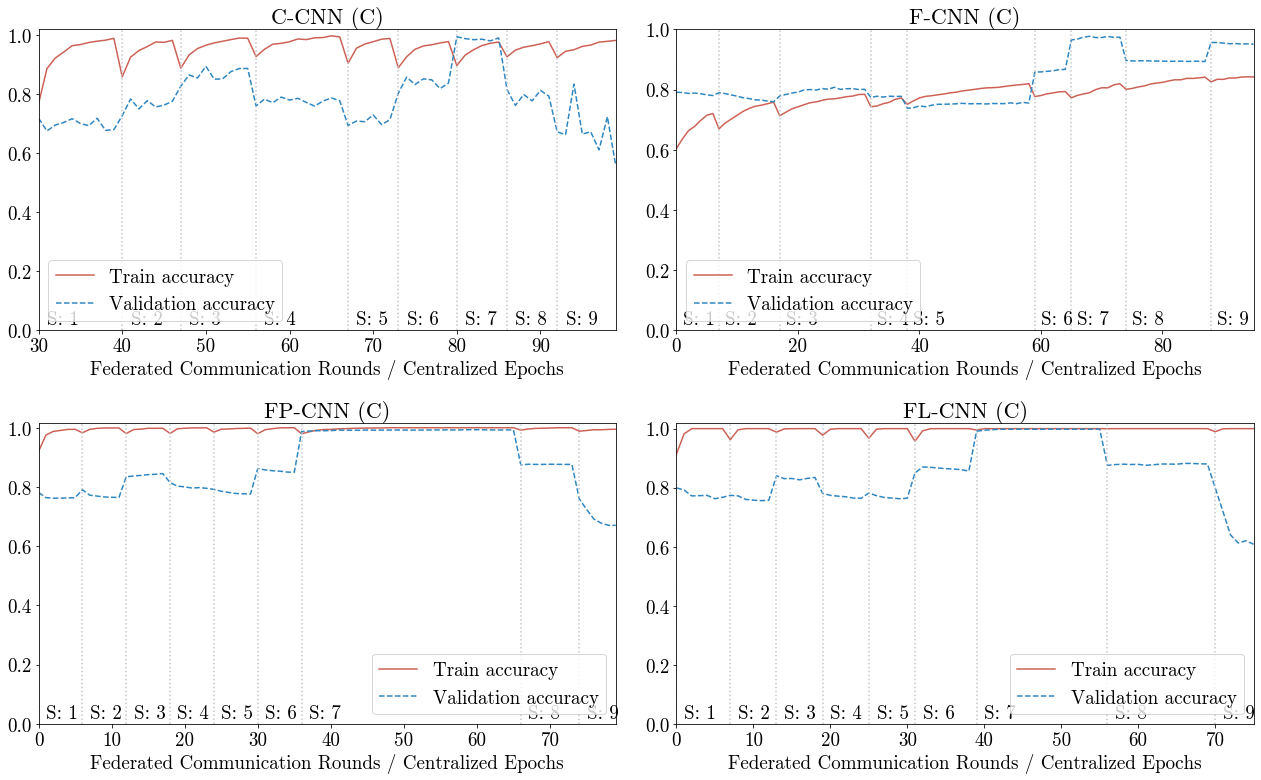

In [60]:
fig, ax = create_simple_grid(file_paths, np.arange(0,1.1,0.2), 'accuracy', top_exp)
fig.savefig(os.path.join(FIGURES, 'trainingaccuracy.pdf'), bbox_inches = 'tight')

### Loss: Train / Val

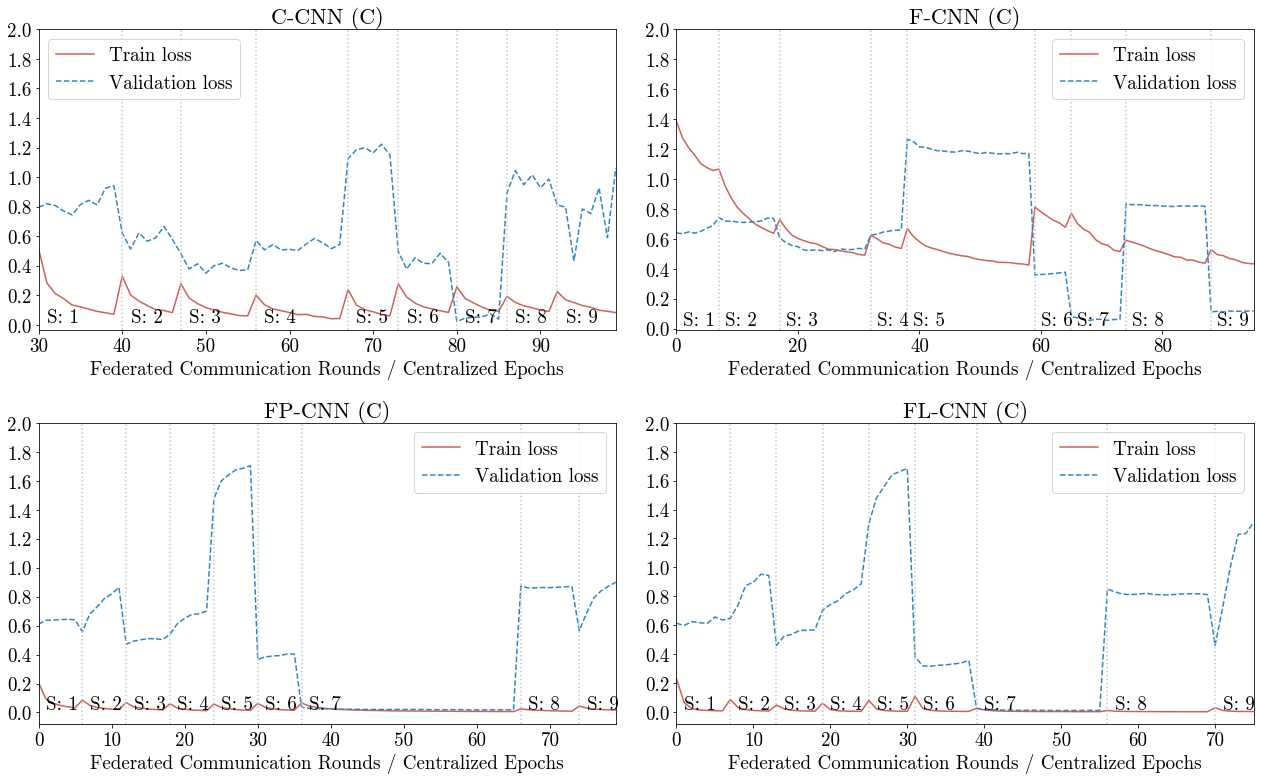

In [61]:
fig, ax = create_simple_grid(file_paths, np.arange(0,2.1,0.2), 'loss', top_exp)
fig.savefig(os.path.join(FIGURES, 'trainingloss.pdf'), bbox_inches = 'tight')

## Share of Pain Level 1

In [42]:
# Set PLT Parameters
plt.rcParams.update({'font.size': 18, 
                     'font.family' : 'cmr10', 
                     'font.weight' : 'normal',
                     'axes.titlesize' : 22})

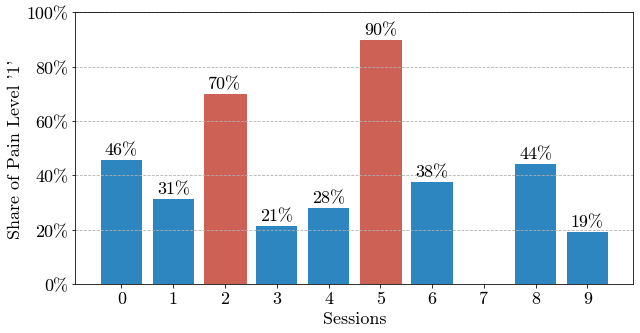

In [43]:
fig, ax = draw_pain_bar_chart()
fig.savefig(os.path.join(FIGURES, 'painbar.pdf'), bbox_inches = 'tight')